In [44]:
import ast
import pandas as pd

def convert_to_list(s):
    return ast.literal_eval(s)

# DataFrameの読み込み
df = pd.read_csv('../results/output.csv', converters={'num_iter_bins': convert_to_list})
df['bytes_per_character'] = df['memory_usage_cdawg'] / df['memory_usage_text']
df['edges_per_character'] = df['num_edges'] / df['text_length']
df['memory_usage_cdawg'] /= 1024.0 * 1024.0
df['memory_usage_ma'] /= 1024.0 * 1024.0
df.drop(25, inplace=True)
df

filename  text_length  num_vertices  num_edges  memory_usage_text  \
0   sources            8             4         10                  8   
1   sources           16             5         18                 16   
2   sources           32             8         36                 32   
3   sources           64            20         76                 64   
4   sources          128            39        148                128   
..      ...          ...           ...        ...                ...   
71  english      8388608       1662446    5573005            8388608   
72  english     16777216       3257089   10894050           16777216   
73  english     33554432       6394592   21388157           33554432   
74  english     67108864      13603168   45439391           67108864   
75  english    134217728      30487059  102211137          134217728   

    memory_usage_cdawg  memory_usage_ma  elapsed_time_lz78  \
0             0.000164         0.000412                0.0   
1             0.000267         0.000732                0.0   
2             0.000507         0.001236                0.0   
3             0.001102         0.002243                0.0   
4             0.002144         0.003754                0.0   
..                 ...              ...                ...   
71           82.803169        56.620880            26848.0   
72          161.946938       106.226440            53974.0   
73          317.948334       203.201523           110521.0   
74          675.688469       391.471710           228035.0   
75         1518.610340       770.896591           468631.0   

                                        num_iter_bins  bytes_per_character  \
0                                           [0, 4, 4]            21.500000   
1                                          [0, 10, 6]            17.500000   
2                                      [0, 15, 15, 2]            16.625000   
3                                  [0, 16, 33, 13, 2]            18.062500   
4                                  [0, 15, 60, 44, 9]            17.562500   
..                                                ...                  ...   
71  [0, 6, 433, 6250, 41198, 158163, 409030, 76697...            10.350396   
72  [0, 7, 554, 7957, 59053, 209141, 574823, 11637...            10.121684   
73  [0, 8, 698, 9240, 65430, 273546, 813150, 17811...             9.935885   
74  [0, 7, 984, 12226, 85725, 381681, 1164561, 266...            10.557632   
75  [0, 7, 1959, 21769, 143751, 675615, 1971478, 4...            11.864143   

    edges_per_character  
0              1.250000  
1              1.125000  
2              1.125000  
3              1.187500  
4              1.156250  
..                  ...  
71             0.664354  
72             0.649336  
73             0.637417  
74             0.677100  
75             0.761532  

[75 rows x 11 columns]

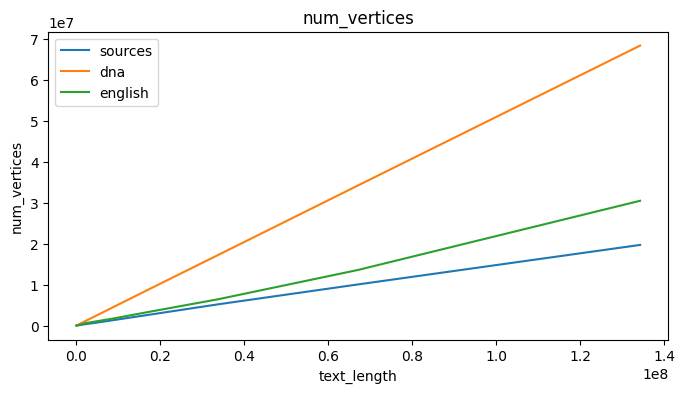

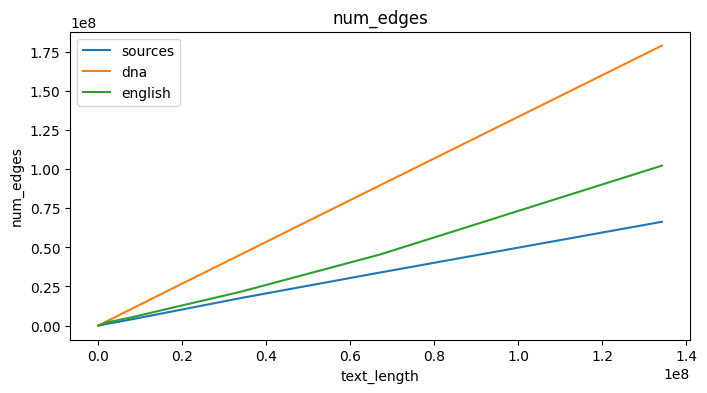

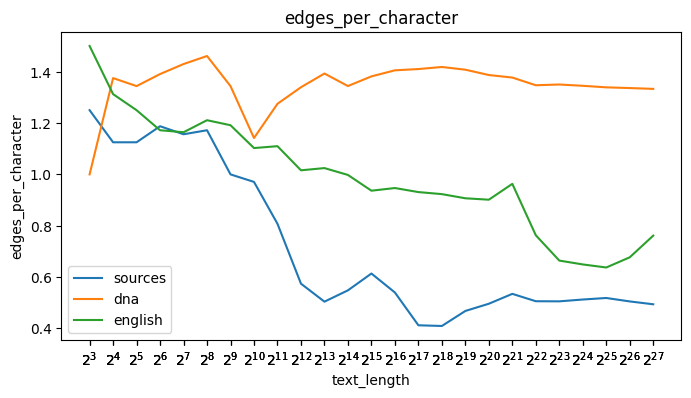

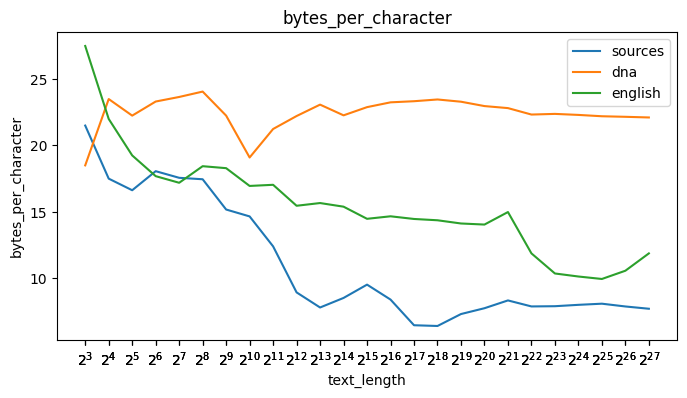

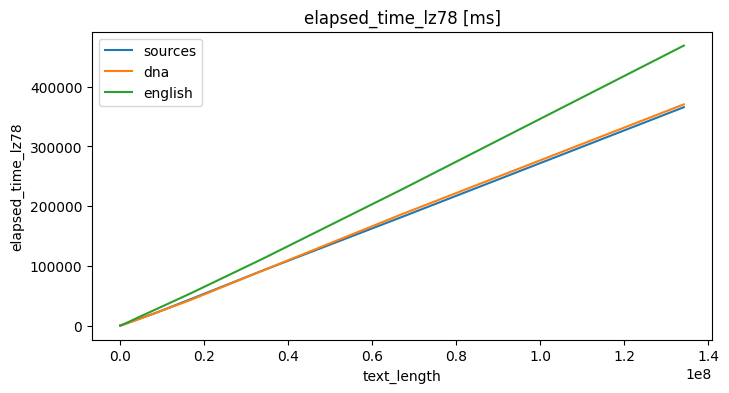

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
import numpy as np


filenames = ['sources', 'dna', 'english']
lengths = [1 << x for x in range(3, 27)]


for label in ['num_vertices', 'num_edges', 'edges_per_character', 'bytes_per_character', 'elapsed_time_lz78']:
    fig, ax = plt.subplots(figsize=(8, 4))
    # for filename in filenames:
    sns.lineplot(df, x='text_length', y=label, hue='filename', ax=ax)
    if label.startswith('memory_usage'):
        ax.set_title(label + ' [kB]')
    if label.endswith('per_character'):
        ax.set_xscale('log', base=2)
        ax.set_xticks(df['text_length'])
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"$2^{{{int(np.log2(x))}}}$"))
        ax.set_title(label + ' [bytes]')
    if label.startswith('elapsed_time_lz78'):
        ax.set_title(label + ' [ms]')
    else:
        ax.set_title(label)

    # handler, label = ax.get_legend_handles_labels()
    # ax.legend(handler, filenames)
    ax.legend()


In [46]:
# create the dataframe such that extract the largest data for each file name
df_max = df[df.text_length == 1 << 27].copy()
df_max.drop(columns=['memory_usage_ma', 'memory_usage_text', 'num_iter_bins'], inplace=True)
df_max

filename  text_length  num_vertices  num_edges  memory_usage_cdawg  \
24  sources    134217728      19702980   66327855          984.544777   
50      dna    134217728      68397775  178908741         2830.198475   
75  english    134217728      30487059  102211137         1518.610340   

    elapsed_time_lz78  bytes_per_character  edges_per_character  
24           365525.0             7.691756             0.494181  
50           370265.0            22.110926             1.332974  
75           468631.0            11.864143             0.761532

In [47]:
# create the dataframe such that extract the largest data for each file name
df_max['sim_memory_usage'] = df_max.num_vertices * 12 + df_max.num_edges * 12
df_max['sim_memory_usage'] /= 1024.0 * 1024.0
df_max

filename  text_length  num_vertices  num_edges  memory_usage_cdawg  \
24  sources    134217728      19702980   66327855          984.544777   
50      dna    134217728      68397775  178908741         2830.198475   
75  english    134217728      30487059  102211137         1518.610340   

    elapsed_time_lz78  bytes_per_character  edges_per_character  \
24           365525.0             7.691756             0.494181   
50           370265.0            22.110926             1.332974   
75           468631.0            11.864143             0.761532   

    sim_memory_usage  
24        984.544773  
50       2830.198471  
75       1518.610336

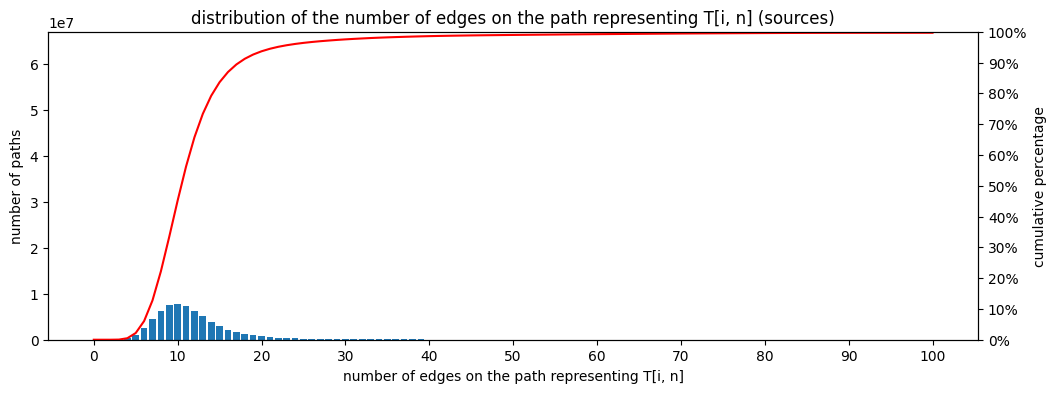

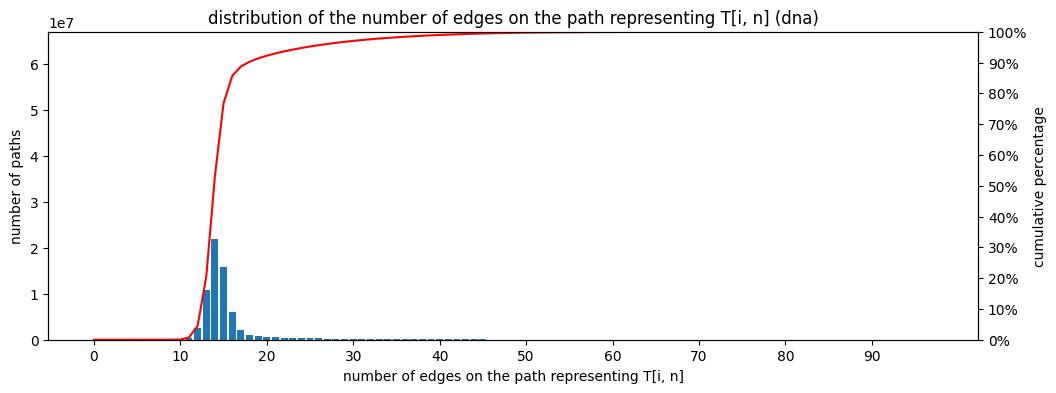

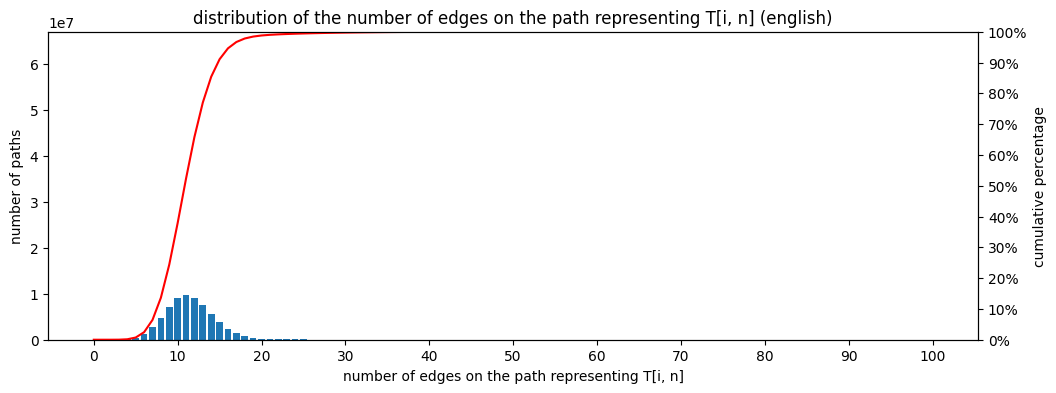

In [48]:
df2 = df.set_index(['filename', 'text_length'])
for filename in filenames:
    fig, ax = plt.subplots(figsize=(12, 4))
    bin = df2.loc[filename, lengths[-1]]['num_iter_bins']
    n = sum(bin)
    bin = bin[:101]

    # Plot the distribution of the number of edges on the path representing S[i, n]
    ax.bar(range(len(bin)), bin)
    ax.set_xticks(range(0, len(bin), 10))
    ax.set_ylim(0, n)
    ax.set_xticklabels(range(0, len(bin), 10))
    ax.set_xlabel('number of edges on the path representing T[i, n]')
    ax.set_ylabel('number of paths')
    # add the cumulative sum of the number of edges on the path representing S[i, n]
    cumsum = np.cumsum(bin)
    ax2 = ax.twinx()
    ax2.plot(range(len(bin)), cumsum, color='red')
    ax2.set_ylim(0, n)
    ax2.set_yticks(range(0, n + 1, n // 10))
    ax2.set_yticklabels([f'{x / n:.0%}' for x in range(0, n + 1, n // 10)])
    ax2.set_ylabel('cumulative percentage')

    ax.set_title(f'distribution of the number of edges on the path representing T[i, n] ({filename})')


    average = sum(map(lambda x: x[0] * x[1], enumerate(bin))) // sum(bin)

    # # Plot vertical line
    # ax.axvline(x=average, color='red', linestyle='--')

    plt.savefig(f'../results/num_iter_bins_{filename}.pdf')
    plt.show()


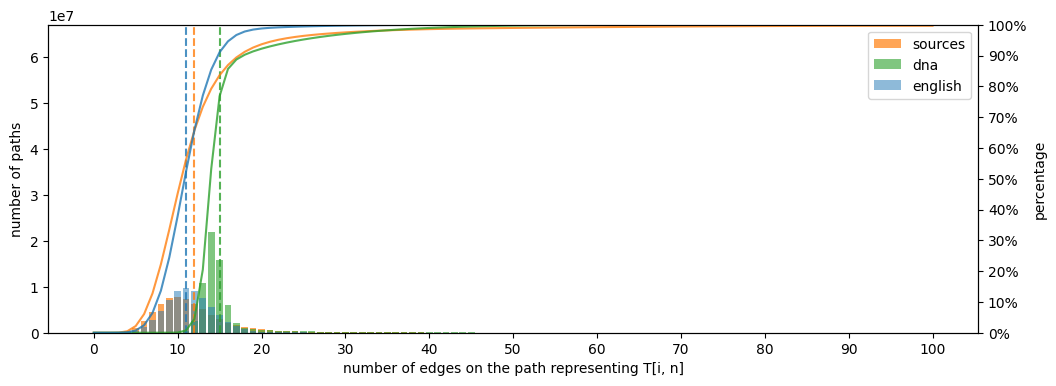

In [59]:
df2 = df.set_index(['filename', 'text_length'])
fig, ax = plt.subplots(figsize=(12, 4))
ax2 = ax.twinx()

colors = { 'sources': 'tab:orange', 'dna': 'tab:green', 'english': 'tab:blue' }

alpha = 0.7

for filename in filenames:
    bin = df2.loc[filename, lengths[-1]]['num_iter_bins']
    n = sum(bin)
    bin = bin[:101]

    # Plot the distribution of the number of edges on the path representing S[i, n]
    ax.bar(range(len(bin)), bin, alpha=alpha, label=filename, color=colors[filename])
    alpha -= 0.1
    ax.set_xticks(range(0, len(bin), 10))
    ax.set_ylim(0, n)
    ax.set_xticklabels(range(0, len(bin), 10))
    ax.set_xlabel('number of edges on the path representing T[i, n]')
    ax.set_ylabel('number of paths')
    # add the cumulative sum of the number of edges on the path representing S[i, n]
    cumsum = np.cumsum(bin)
    ax2.plot(range(len(bin)), cumsum, color=colors[filename], alpha=0.8)
    ax2.set_ylim(0, n)
    ax2.set_yticks(range(0, n + 1, n // 10))
    ax2.set_yticklabels([f'{x / n:.0%}' for x in range(0, n + 1, n // 10)])
    ax2.set_ylabel('percentage')

    average = sum(map(lambda x: x[0] * x[1], enumerate(bin))) // sum(bin)

    # # Plot vertical line
    ax.axvline(x=average, linestyle='--', color=colors[filename], alpha=0.8)
ax.legend()
plt.savefig(f'../results/num_iter_bins.pdf')
plt.show()
